# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import optimize

In [4]:
# fundamental units
T_unit = 120 # K
k_B = 1.380649 #x 10^-23 J k^-1
len_unit = 0.34 # x 10^-9 m
mass_unit = 39.948 #amu

en_unit = T_unit * k_B #J
p_unit = en_unit / (len_unit**3) # x 10^4 Pa = J/m^3

### Exercise 7.1

Use the Monte Carlo NVT code we have provided to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.

First we estimate how long it takes for the system to equilibrate. We monitor the instant energy in a sequence of short simulations -1000 Monte Carlo steps long- to determine after how long the energy value stabilizes around a mean value. We choose this strategy of short simulations to reach an accurate enough estimate while saving some time.

To monitor the instant energy without changing the code too much, we run a set of simulations with $10^3$ blocks of 1 step each, so that the block average printed in the files coincides with the value of the energy at each step.

In [5]:
filename = ['gas','liquid','solid']
filetype = ['energy','pressure']
color_ = ['xkcd:sky blue', 'xkcd:crimson', 'xkcd:grass green']
color_cycle=[['xkcd:forest green','xkcd:grass green','xkcd:spring green'],['xkcd:crimson', 'xkcd:orange','xkcd:bright yellow']]

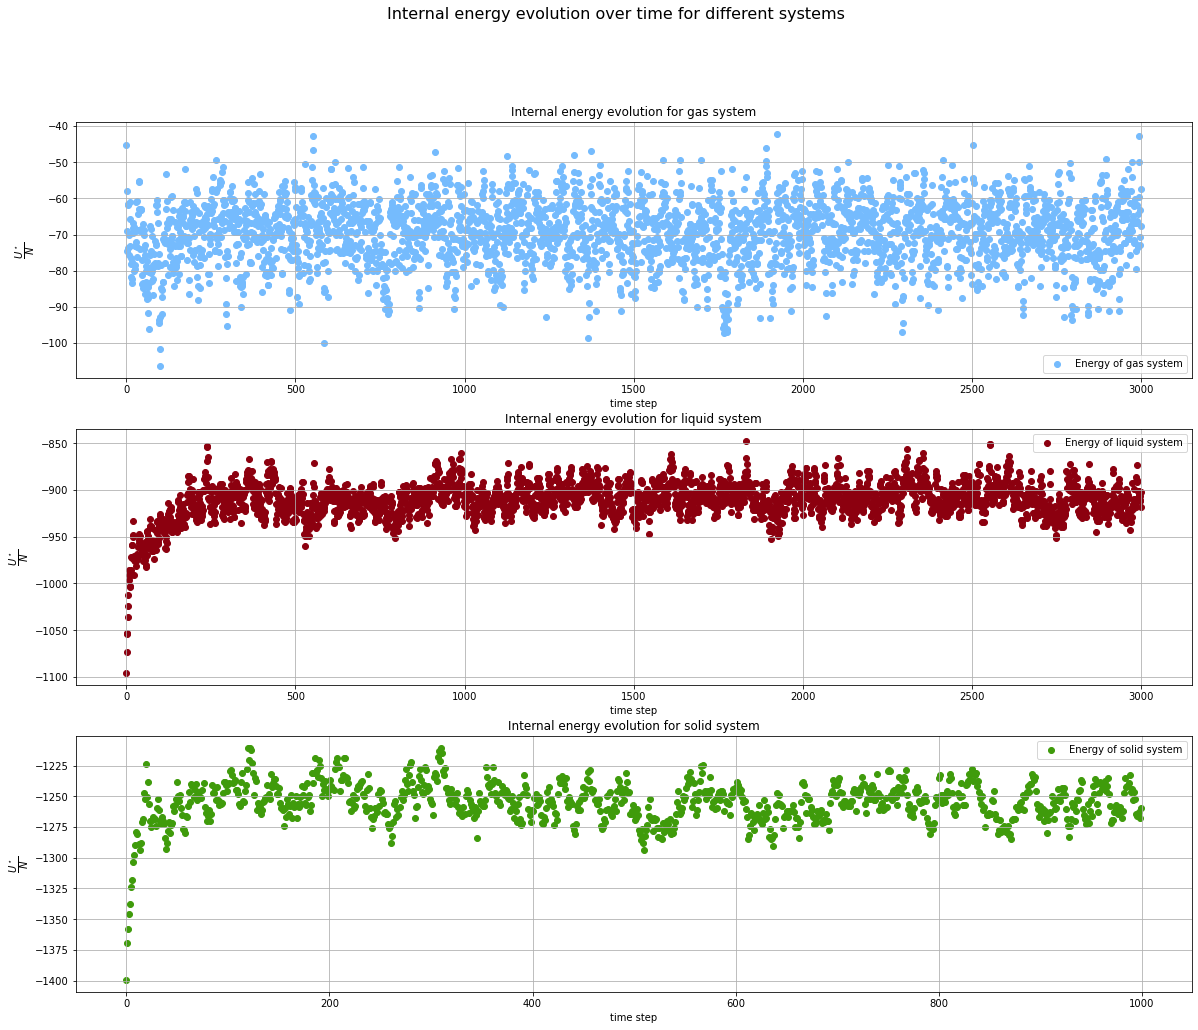

In [6]:
# equilibration evolution of energy
fig,axs = plt.subplots(3, 1, figsize=[20,16])
fig.suptitle('Internal energy evolution over time for different systems', fontsize=16)

for i in range(3):
    u_inst = np.loadtxt("MC_NVT_data/test/output.epot." + filename[i]+".txt", usecols=(1), unpack='true')
    time = np.arange(len(u_inst))
    u_av = np.average(u_inst)
    #axs[i].set_ylim([u_av-1,u_av+1])
    axs[i].scatter(time, u_inst*en_unit, label ='Energy of '+ filename[i] +' system', c=color_[i])
    axs[i].legend()
    axs[i].set_title('Internal energy evolution for '+ filename[i] +' system')
    axs[i].set_xlabel('time step')
    axs[i].set_ylabel('$ \dfrac {U^\star}{N}$')
    axs[i].grid(True)

plt.show()

It can be seen quite clearly that both liquid and solid simulations equilibrate very fast, after around $200$ steps; to make sure the system is really stable, we'll take an equilibration time about 10 times larger. As for the Molecular Dynamics simulation, this empirical method to consider when the system has thermalised is obviously not exact: we just consider the fluctuations around the average which, especially for the solid, usually is slightly below the ideal value. This will lead to some discrepancies in the final results.

For the gas system the same issue of the starting conditions apply, as for the molecular dynamics: we cannot begin from a crystalline lattice and hope it will equilibrate in a reasonable ammount of time, as it would be like waiting for an ice cube to evaporate. The more reasonable solution is to begin from the final liquid configuration. We can see that the system presents quite a stable instantaneous energy, with fluctuations around the average comparable to the liquid and solid.

Similar considerations can be made also looking at the evolution of pressure, shown in the following graphs:

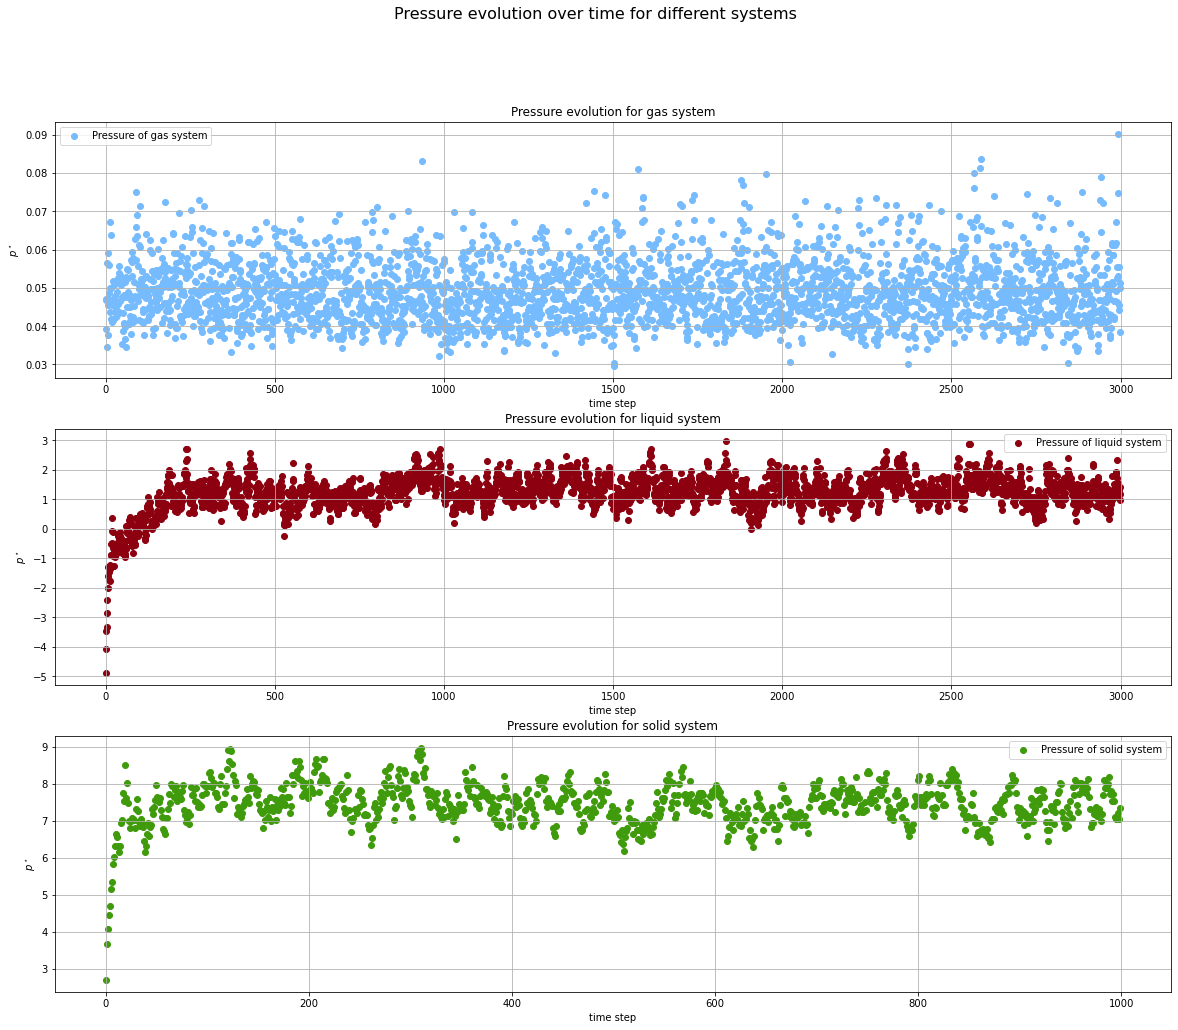

In [5]:
# equilibration evolution of pressure
fig,axs = plt.subplots(3, 1, figsize=[20,16])
fig.suptitle('Pressure evolution over time for different systems', fontsize=16)
for i in range(3):
    p_inst = np.loadtxt("MC_NVT_data/test/output.pres." + filename[i] +".txt", usecols=(1), unpack='true')
    time = np.arange(len(p_inst))
    axs[i].scatter(time, p_inst, label ='Pressure of '+ filename[i] +' system', c=color_[i])
    axs[i].legend()
    axs[i].set_title('Pressure evolution for '+ filename[i] +' system')
    axs[i].set_xlabel('time step')
    axs[i].set_ylabel('$p^\star$')
    axs[i].grid(True)
plt.show()

As for the Molecular Dynamics exact evolution, pressure is estimated from the average of the virial, with the addition of tail corrections for contributes outside the cut-off radius.

After the equilibration phase is reached, we execute other runs in order to estimate the self-correlation function for each system, in order to determine the optimal block size. The following code determines $\chi$ both for $U/N$ and $p$ of the system.

In [10]:
t_tot = 500000        # length of long simulations
t = np.arange (t_tot)
t_ran = 1000          # maximum interval size to compute self-correlation 

# prints .long data
filename = ['solid','liquid','gas',]
filetype = ['energy','pressure']
color_ = ['xkcd:sky blue', 'xkcd:crimson', 'xkcd:grass green']
color_cycle=[['xkcd:forest green','xkcd:grass green','xkcd:spring green'],['xkcd:ocean blue', 'xkcd:azure','xkcd:sky blue']]

en_array = []
p_array = []

In [11]:
# loads very long arrays from long simulations

for i in range (3):
    en = np.loadtxt("MC_NVT_data/test/output.epot." + filename[i] +".long" +".txt", usecols=(1), unpack='true')
    en_array.append(en)
    p = np.loadtxt("MC_NVT_data/test/output.pres." + filename[i] +".long"+".txt", usecols=(1), unpack='true')
    p_array.append(p)

arrays = [en_array, p_array]

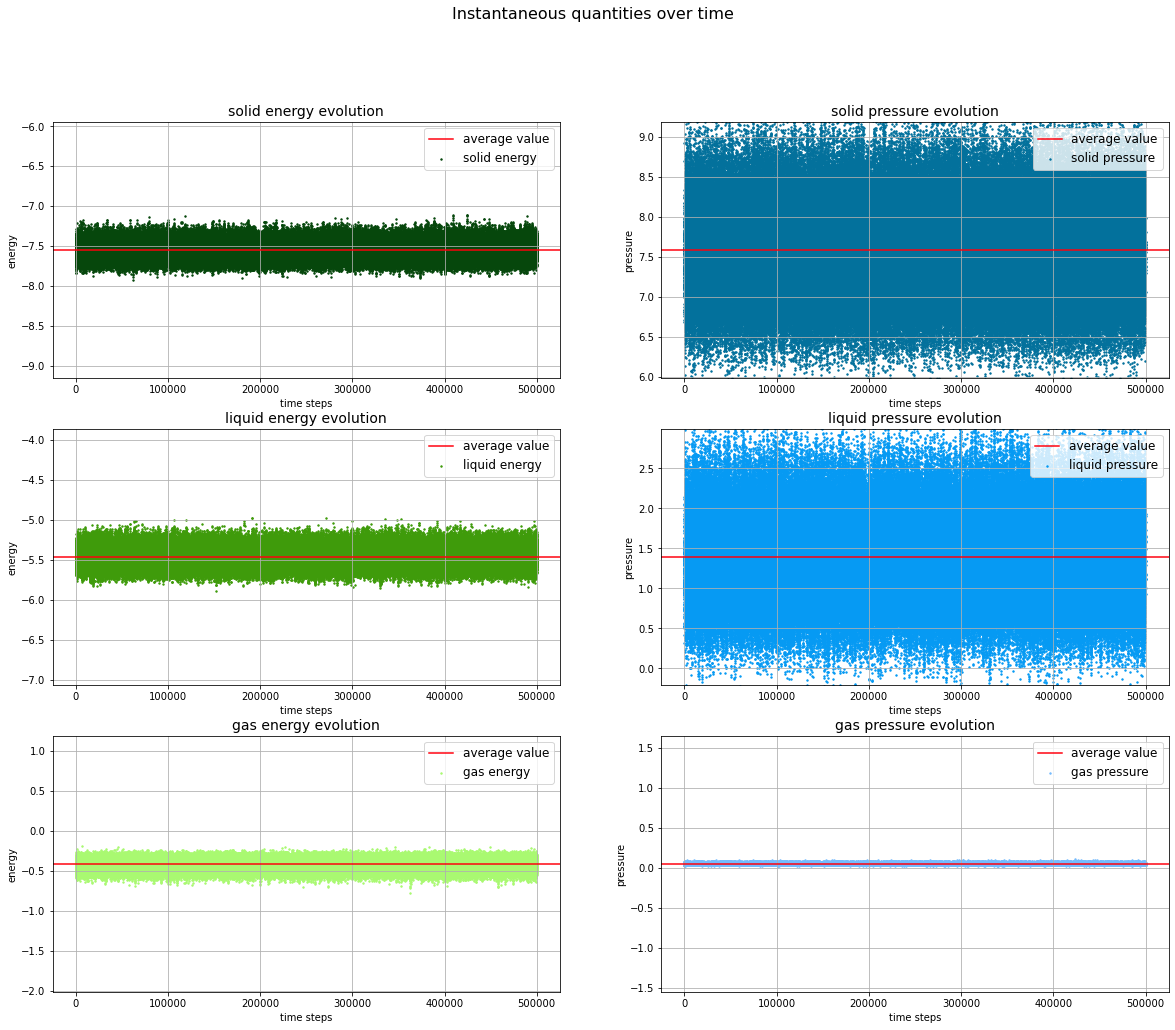

In [12]:
# plots energy and pressure on long sims
fig,axs = plt.subplots(3, 2, figsize=[20,16])
fig.suptitle('Instantaneous quantities over time', fontsize=16)
for j in range (2):
    for i in range(3):
        axs[i][j].scatter(t, arrays[j][i], s=2, label = filename[i]+ " " +filetype[j] , color=color_cycle[j][i])
        axs[i][j].legend()
        av = np.average(arrays[j][i])
        axs[i][j].axhline(y=av, color='xkcd:bright red', label = 'average value')

        axs[i][j].set_ylim([av-1.6,av+1.6])
        axs[i][j].set_xlabel('time steps')
        axs[i][j].set_ylabel(filetype[j])
        axs[i][j].grid(True)
        axs[i][j].legend(fontsize='large',loc='upper right')
        axs[i][j].set_title(filename[i]+" "+filetype[j] + " evolution", fontsize = 14)

plt.show()

These graphs simply show all instantaneous values of energy and pressure for the different systems during a simulation of $5\times 10^5$ steps. While energies appear quite stable, pressure tends to take many different values, since the virial strongly depends on the particular configuration. In the gas system, the particles interact so little that pressure is essentially the kinetic term with only small correctoins due to the virial.

Trying to determine the uncertainty on these whole samples would certainly lead to enormous errors, so we have to determine the best way to separate these data into blocks: the average remains the same, but the fluctuations are damped through subsequent partial averages. In order to do so, the blocks need to represent completely different samples, so the data needs to be uncorrelated.

By looking at the autocorrelation function $\chi$, we can determine after how many time-steps the data stops being correlated. Assuming an exponential correlation in time, $\chi \approx e^{-t/t_c}$, the correlation time $t_c$ is the typical time-scale when auto-correlatoin drops off; by taking blocks at least $2t_c$ long we are sure that the subsequent block averages are completely indipendent. 

In [13]:
#self-correlation function
def self_corr(t_max, t_range, array):
    X = []
    m = np.sum(array)
    m_2 = np.sum(array*array)
    sigma_m = m_2/t_max - (m/t_max)**2

    for t in range(t_range):
        dt = t_max - t
        m = np.sum(array[:dt])
        m1 = np.sum(array[t:])
        m_m1 = np.sum(array[:dt]*array[t:])
        X.append((m_m1/dt - (m*m1)/(dt*dt))/sigma_m)
    return X

In [14]:
# self-correlation for different quantities and data
x_vec_en = []
x_vec_p = []
for i in range (3):
    x_vec_en.append (self_corr(t_tot,t_ran, arrays[0][i]))
    x_vec_p.append (self_corr(t_tot,t_ran, arrays[1][i]))

x_vec = [x_vec_en, x_vec_p]
t_range = np.arange(t_ran)

In [15]:
# fit self-correlation w/ exponential 
def exp_fit (x, a, b, t_c):
    return a*np.exp(-x*t_c) + b

en_params = []
p_params = []
t_c = [] 

for i in range (3):
    popt_en, popc = optimize.curve_fit(exp_fit, t_range, x_vec[0][i])
    en_params.append (popt_en)
    t_c.append(1/popt_en[2])
    popt_p, popc = optimize.curve_fit(exp_fit, t_range, x_vec[1][i])
    p_params.append (popt_p)
    t_c.append(1/popt_p[2])
    
params = [en_params, p_params]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


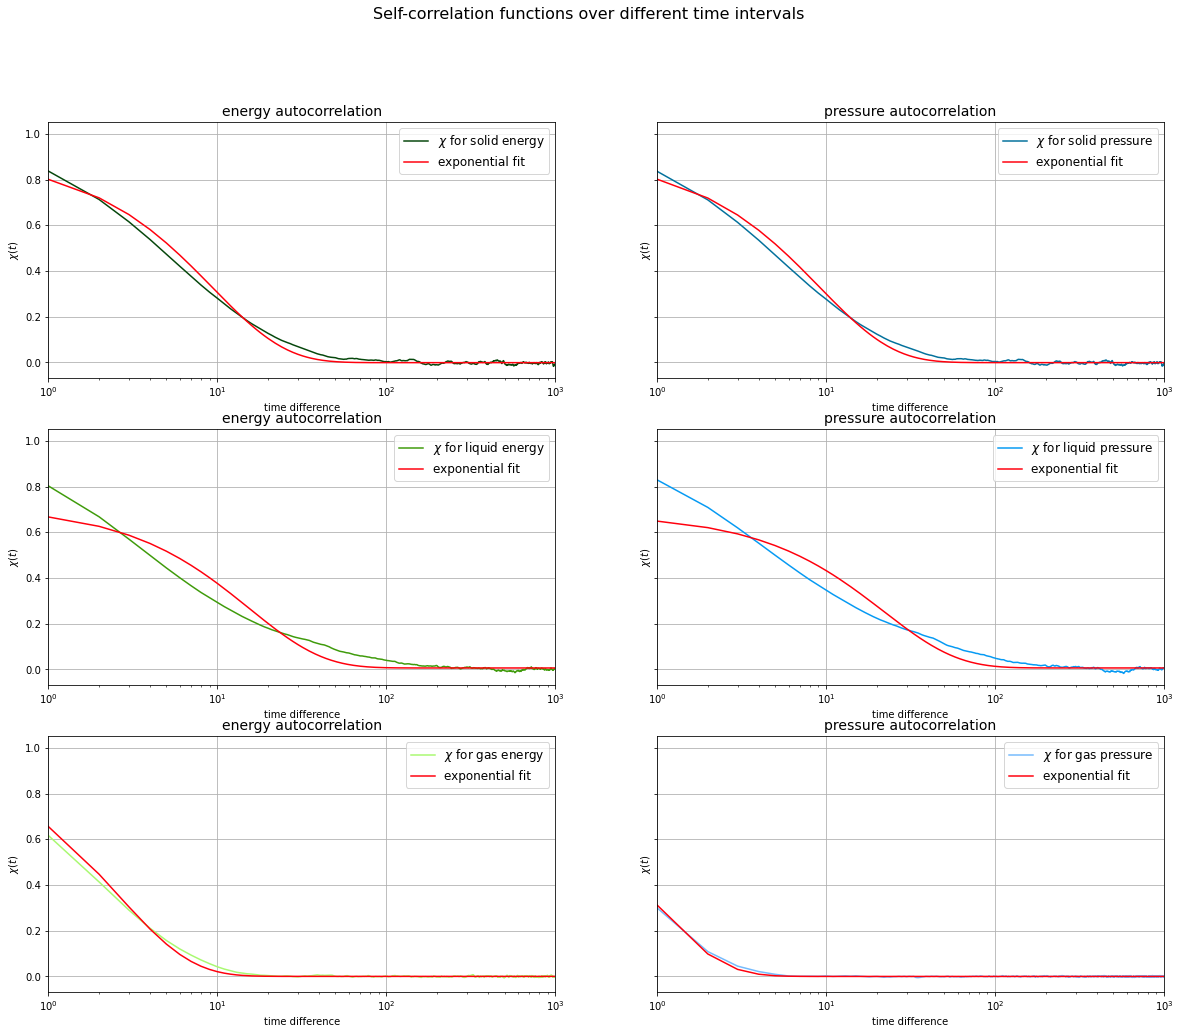

[9.370169337755284, 9.189089240503083, 15.529631853304826, 21.930939576482615, 2.6031329352112773, 0.8624880780980264]


In [16]:
# plots self_correlations for energy and pressure on long sims
fig,axs = plt.subplots(3, 2, figsize=[20,16], sharey=True)
fig.suptitle('Self-correlation functions over different time intervals', fontsize=16)
for j in range (2):
    for i in range(3):
        axs[i][j].plot(t_range, x_vec[j][i], markersize= 20, label = "$\chi$ for " + filename[i]+ " " +filetype[j] , color=color_cycle[j][i])
        axs[i][j].plot(t_range, exp_fit(t_range, *params[j][i]), label = 'exponential fit', c = 'xkcd:bright red')
        axs[i][j].legend()
        axs[i][j].set_xlim([1,1000])
        axs[i][j].set_xscale('log')
        axs[i][j].set_xlabel('time difference')
        axs[i][j].set_ylabel('$\chi (t)$')
        axs[i][j].grid(True)
        axs[i][j].legend(fontsize='large')
        axs[i][j].set_title(filetype[j] + " autocorrelation", fontsize = 14)

plt.show()

print (t_c)

We see the comparison between the actual autocorrelation function and the exponential fit. We can extract the correlation time from the fit. We see from these values that the Monte Carlo steps actually guarantee quite uncorrelated measures, with maybe the exception of the liquid. From this results we see that we would need at least 50 time steps in each block for the averages to be uncorrelated. We clearly see that the correlation steadily fluctuates around 0 after about 100 steps for every system.

However, we cannot have too large blocks, or the error for each would increase too much.

In [17]:
block_size =[1, 2, 4, 10, 20, 40, 100, 200, 400, 1000, 2000, 4000, 10000, 20000]
dev_std = []

for L in block_size:
    N = int (t_tot / L)      # number of blocks
    g_av = 0
    g_av_2 = 0
    k = 0                    # true position index
    
    for i in range(N):
        av = 0
        av_2 = 0
        
        for i in range (L):
            val = en_array[0][k]
            av += val
            av_2 += val**2
            k+=1
            
        g_av += av / L
        g_av_2 += av_2 / L
        
    dev_std.append(((g_av_2/N - (g_av/N)**2))**(1/2))


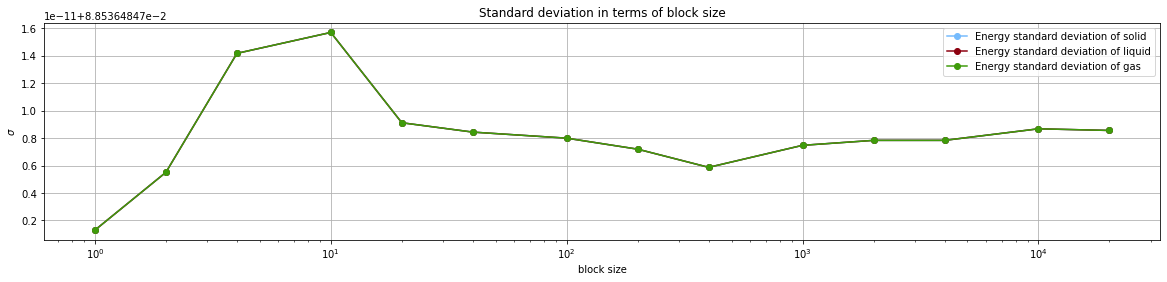

In [18]:
fig = plt.figure(figsize=[20,4])
for i in range (3):
    plt.plot(block_size, dev_std, label ='Energy standard deviation of '+ filename[i], c=color_[i], marker='o')
plt.legend()
plt.title('Standard deviation in terms of block size')
plt.xlabel('block size')
plt.xscale('log')
plt.ylabel('$\sigma$')
plt.grid(True)
plt.show()

Finally we compare the standard deviation for different block sizes. We notice first of all that the standard deviation does not depend directly on the type of data, as the graph is the same for all three model, but only on their distribution.
Assuming that the data are distributed normally around the average, by increasing the block size the variables tend to be distributed on a gaussian of fixed width: we can see how the standard deviation tends to an asymptote, which represents the $\sigma$ of the data distribution. There thus no particular interest of having too large blocks, as the uncertainty inside the block remains fixed after a certain size.

The right block size needs to be large enough for the blocks to be unrelated, without being too big or the simulations would spend too many resources. I did my simulations using 100 blocks of 1000 steps each, in order to be completely sure of the lack of correlation but most importantly to have a sample large enough to damp all fluctuations.

### Exercise 7.2

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the Monte Carlo NVT code</span> we have provided: average value of $g(r)$ in each block (with output in the file: output.gofr.0), final average value of $g(r)$ with statistical uncertainties (with output in the file: output.gave.0).

### Exercise 7.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code</span>.

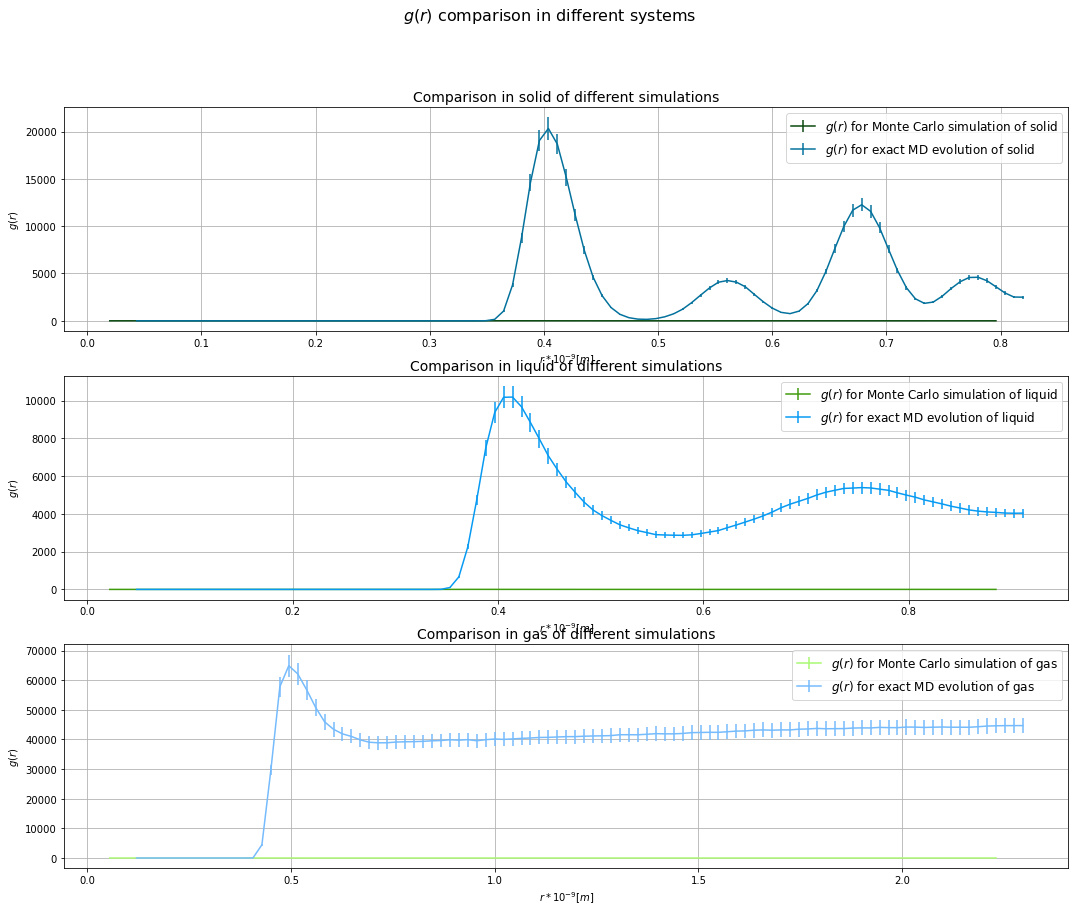

In [19]:
fig, axs = plt.subplots (3, 1, figsize = [18,14])
fig.suptitle ('$g(r)$ comparison in different systems', fontsize = 16)
for i in range (3):
    r, gr_MC, gr_MC_err = np.loadtxt("MC_NVT_data/data/output.gave." + filename[i]+".txt", usecols=(0,1,2), unpack = True)
    r1, gr_MD, gr_MD_err = np.loadtxt("MC_NVT_data/data/g_of_r." + filename[i]+".txt", usecols=(0,1,2), unpack = True)
    
    axs[i].errorbar (r*len_unit, gr_MC, yerr = gr_MC_err, color = color_cycle[0][i], label = "$g(r)$ for Monte Carlo simulation of "+filename[i])
    axs[i].errorbar (r1*len_unit, gr_MD, yerr = gr_MD_err, color = color_cycle[1][i], label = "$g(r)$ for exact MD evolution of "+filename[i])
    axs[i].set_xlabel ('$r *10^{-9}[m]$')
    axs[i].set_ylabel ('$g(r)$')
    axs[i].set_title ('Comparison in '+filename[i]+' of different simulations', fontsize = 14)
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
plt.show()
#

The graphs compare the two-particle distribution function of the different systems obtained from the Metropolis simulation and from the Molecular Dynamics simulation. Although not exactly the same, we notice the same features in both cases.
- First of all, there is a minimum distance between two particles which corresponds to the double of the radius, since the particles have finite sizes and cannot penetrate each other.
- The solid presents distinct peaks in proximity of the characteristic distances between the crystalline lattice sites: the particles have very few possibility of motion, therefore the distances are fixed.
- The liquid still presents distances with a higher population, but much less marked than the solid counterpart: the molecules tend to get disordered
- Finally the gas has only a small peak very close to the particle size but at larger distances uniforms to unity. The particle feel the attraction force only when really close, so some tend to remain close to one another; the moment the distance between them increases, they stop interacting and disperse at any distance, the system acts like an ideal, non-interacting gas, so $g(r) \approx 1$ as it simply describes product of single-particle distributions.

### Exercise 7.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units

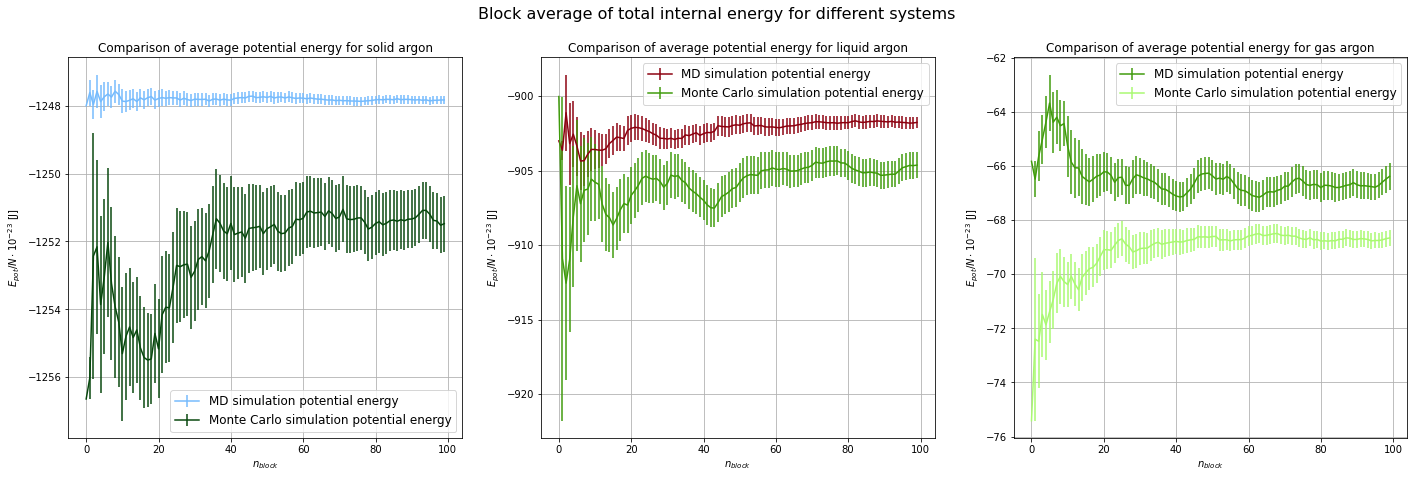

In [20]:
#potential energy
fig,axs = plt.subplots(1, 3, figsize=[24,7])
fig.suptitle('Block average of total internal energy for different systems', fontsize=16)

for i in range (3):
    E_tot, E_err = np.loadtxt("MC_NVT_data/data/ave_epot."+filename[i]+".txt", usecols=(0,1), unpack='true')
    x = np.arange(len(E_tot))
    axs[i].errorbar(x, E_tot*en_unit, yerr=E_err*en_unit, label ='MD simulation potential energy', c=color_[i])
    
    E_tot, E_err = np.loadtxt("MC_NVT_data/data/output.epot." + filename[i]+".long.txt", usecols=(2,3), unpack='true')
    x = np.arange(len(E_tot))
    axs[i].errorbar(x, E_tot*en_unit, yerr=E_err*en_unit, label ='Monte Carlo simulation potential energy', c=color_cycle[0][i])
    
    axs[i].set_xlabel('$n_{block}$')
    axs[i].set_ylabel('$E_{pot}/N \cdot 10^{-23}$ [J]')
    axs[i].set_title('Comparison of average potential energy for '+filename[i] + ' argon')
    axs[i].legend(fontsize='large')
    axs[i].grid(True)
plt.show()

We now compare the results of the simulation of the same system evolved with the two different methods.
The potential energy per particle does not match quite well, but results are compatible one another in at least a $2\sigma$ interval. The Metropolis evolution tends to yield less precise result, due to the high stocacity of moves; the results are otherwise quite reliable, since the sample are taken at fixed temperature for a long enough time at equilibration. 
On the other hand, the exact evolution with Verlet's algorithm might give more precise results, but appear a little off the expected values. 

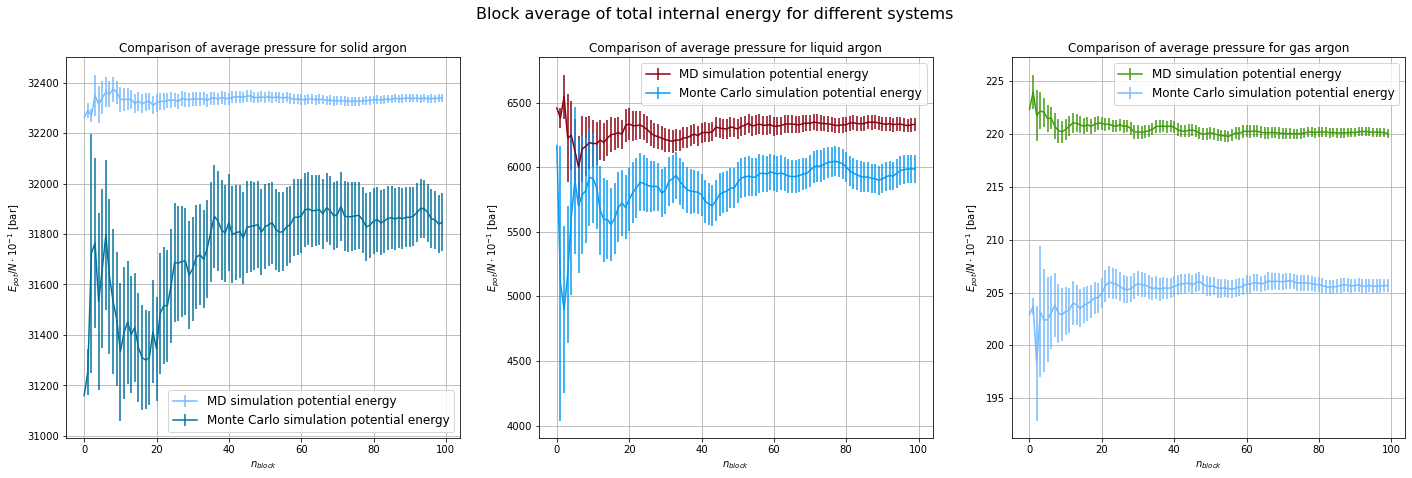

In [21]:
# pressure
fig,axs = plt.subplots(1, 3, figsize=[24,7])
fig.suptitle('Block average of total internal energy for different systems', fontsize=16)

for i in range (3):
    P_tot, P_err = np.loadtxt("MC_NVT_data/data/ave_pres."+filename[i]+".txt", usecols=(0,1), unpack='true')
    x = np.arange(len(P_tot))
    axs[i].errorbar(x, P_tot*p_unit, yerr=P_err*p_unit, label ='MD simulation potential energy', c=color_[i])
    
    P_tot, P_err = np.loadtxt("MC_NVT_data/data/output.pres." + filename[i]+".long.txt", usecols=(2,3), unpack='true')
    x = np.arange(len(P_tot))
    axs[i].errorbar(x, P_tot*p_unit, yerr=P_err*p_unit, label ='Monte Carlo simulation potential energy', c=color_cycle[1][i])
    
    axs[i].set_xlabel('$n_{block}$')
    axs[i].set_ylabel('$E_{pot}/N \cdot 10^{-1}$ [bar]')
    axs[i].set_title('Comparison of average pressure for '+filename[i] + ' argon')
    axs[i].legend(fontsize='large')
    axs[i].grid(True)
plt.show()

As for the potential energy, the results are consistent but not exaclty compatible between the two methods. In this particular example, the temperature difference is key, since the pressure estimate depedns directly on the value of $T$. In the Metropolis evolution temperature is a fixed parameter from the outside, which determines the Boltzmann probability distribution that gets sampled. On the other hand, in Verlet's algorithm temperarture is estimated as the mean kinetic energy, which depends on the particular configuration of the system. By averaging over different blocks the fluctuations get damped, yielding precise values; however, if $T$ is slightly off the value of $T^{\star}$, it will be hard for the system to stabilise exactly at that value, therefore there will be a discrepancy with the real value.